In [1]:
###Import
import glob
import timeit
import numpy as np
import cv2 as cv
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import copy
from matplotlib import colors
from math import pi
import os
import re


#To run project notebooks in subfolders as from root folder
import sys
sys.path.append('../../')

###Import self-written library
import featexlib
from featexlib import Debug as dbug
from featexlib import *

plt.style.use('seaborn-whitegrid')

#for autorealoading the submodules
%load_ext autoreload
%autoreload 2

In [2]:
###Active cell###
#Y is in RGB format or one channel
sp_y_is_rgb = False
sp_cv_read_mode = cv.IMREAD_COLOR if sp_y_is_rgb else cv.IMREAD_UNCHANGED
interp_y = cv.INTER_NEAREST #Remove interpolation for y class

Totally 294 pair images found
 ['../../Data/scrapid/images_and_annotations/1_channel/images_protocols_matched/2021-10-31_10_08_35_153_019/2021-10-31_10_08_35_153_019.png']
 ['../../Data/scrapid/images_and_annotations/1_channel/masks/Thumbs.db']
Num classes 11
Shape (293, 1071, 3557)
Unique classes: [ 0  2  3  4  5  6  7  8  9 10]


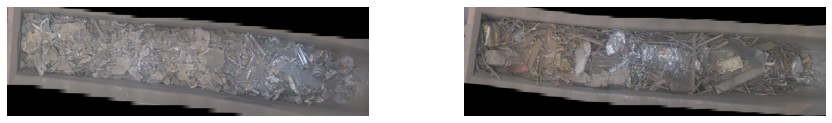

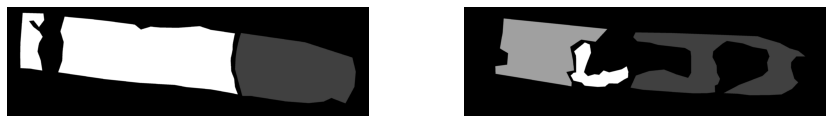

In [3]:
###ACTIVE CELL###
###FROM ONE CHANNEL Y
###Prepare X dataset, reading from directory

images_x, images_y_raw = Image_generator.load_from_folders_xy(
    save_dir_x = "../../Data/scrapid/images_and_annotations/1_channel/images_protocols_matched",
    save_dir_y = "../../Data/scrapid/images_and_annotations/1_channel/masks",
    size=(3557,1071),
    file_filter_regex = r'/([^/]+)\.png',
    cv_read_mode = sp_cv_read_mode,
    recursive = True,
    interp_y = interp_y
)

dbug.show_images_list(images_x[:2], col_number = 2)
dbug.show_images_list(images_y_raw[:2], col_number = 2)
print('Num classes', images_y_raw.max()+1)
print('Shape',images_y_raw.shape)
print('Unique classes:', np.unique(images_y_raw))

Totally 10 pair images found
Shape (10, 1071, 3557, 3)


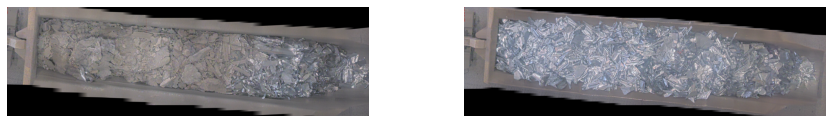

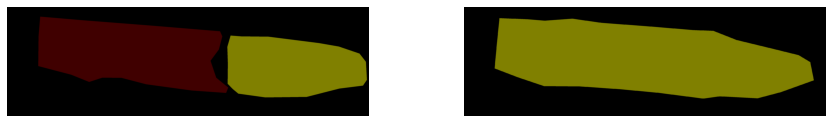

In [21]:
###ACTIVE CELL###
###FROM ONE CHANNEL Y
###Prepare X dataset, reading from directory

images_x, images_y_raw = Image_generator.load_from_folders_xy(
    save_dir_x = "../../Data/scrapid/images_and_annotations/JPEGImages",
    save_dir_y = "../../Data/scrapid/images_and_annotations/SegmentationClassPNG",
    size=(3557,1071),
    file_filter_regex = r'/([^/]+)\.jpg',
    cv_read_mode = sp_cv_read_mode,
    recursive = False,
    interp_y = interp_y
)

dbug.show_images_list(images_x[:2], col_number = 2)
dbug.show_images_list(images_y_raw[:2], col_number = 2)
print('Shape',images_y_raw.shape)

Decimal code is 8


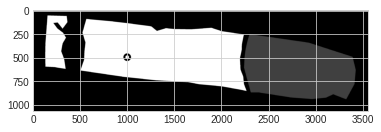

In [4]:
####FOR DEBUG###
###Find new color codes
circle_color = (250, 70, 70) #Set rgb color for point
arr_num = 0 ###Put coords here
coords = (1000,500) ###Put pic number
######################################

if not sp_y_is_rgb:
    circle_color = 0

#Help function to get decimal code of color
def rgb_to_dec(inp):
    return inp[0]*65536+inp[1]*256+inp[2]

#Select an image
pic = np.array(images_y_raw[arr_num])
pic_c = cv.circle(pic, coords, 30, 0, 20)
dbug.show_image(pic_c)

if sp_y_is_rgb: 
    print('RGB decimal code is', rgb_to_dec(pic[tuple(reversed(coords))]))
else:
    print('Decimal code is', pic[tuple(reversed(coords))])

x.shape = (293, 256, 768, 3) , y.shape = (293, 256, 768)


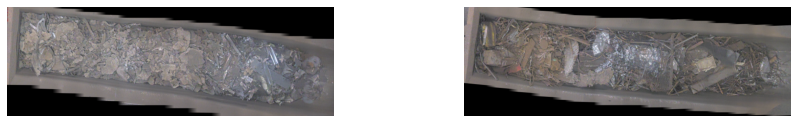

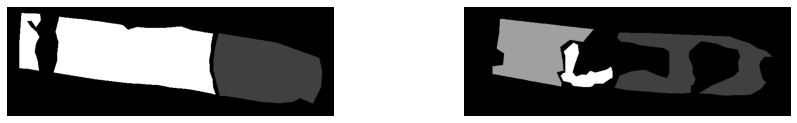

In [5]:
###ACTIVE CELL###
#Configure image generation pipeline, based on Image_generator class
bill_img_gen = Image_generator(
    Image_generator.Pipeline_x_y_images(
        common_layers = [
            #Image_generator.Mod_linear_transf(l=0.2, r=0.0, t = 0.2, b = 0.0, rand = False, target="all"),
            #Image_generator.Mod_add_padding(pl=2, pr=2, pt=2, pb=2, target="all"),
            #Image_generator.Mod_crop(t=0, l=0, h=500, w=500, target="all"),
            Image_generator.Mod_resize(size=(768,256), target="x"),
            Image_generator.Mod_resize(size=(768,256), target="y", interpolation = cv.INTER_NEAREST)
            ###interpolation cv.INTER_NEAREST is required!!!!!
        ],
        special_layers = [[]]
    )
)

#Generate images. Run twice while need to export images_y_raw color images. TODO: optimisation
x_result, images_y_raw = bill_img_gen(images_x, images_y_raw)


#Show some result images
print('x.shape =',x_result.shape,',', 'y.shape =',images_y_raw.shape)

#Show some result
dbug.show_images_list(x_result[0:2,...], col_number = 2) 
dbug.show_images_list(images_y_raw[0:2,...], col_number = 2) 

y shape (293, 256, 768, 11)


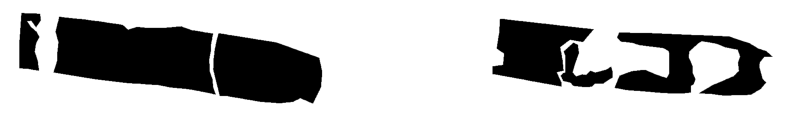

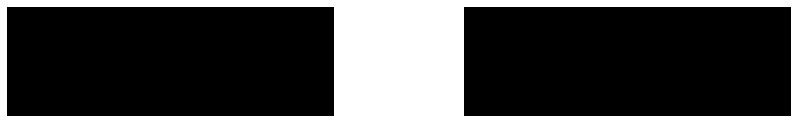

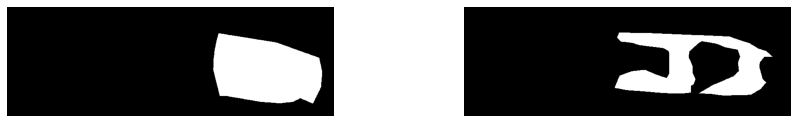

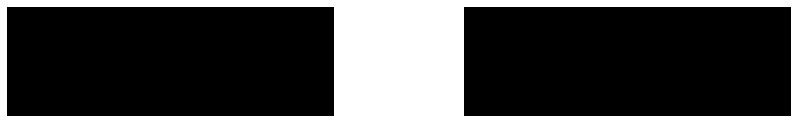

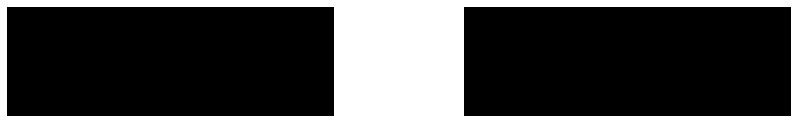

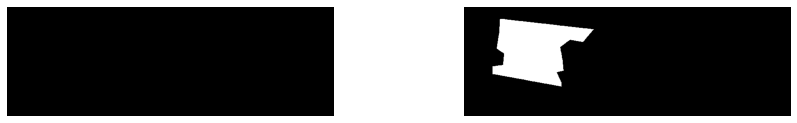

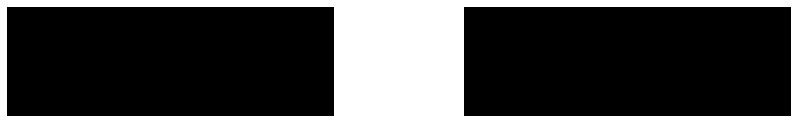

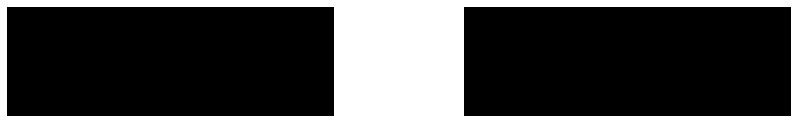

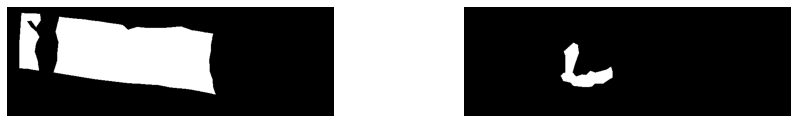

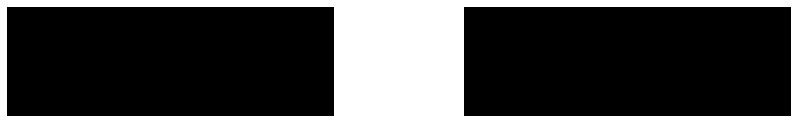

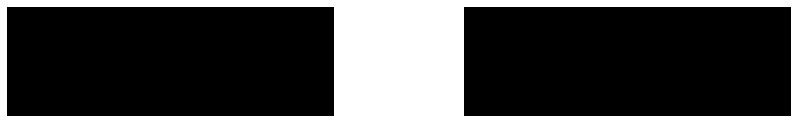

In [6]:
###ACTIVE CELL###
###Make multi class y array

#List of codes for RGB y, do not change the order!
list_of_codes_colors = [
    0, #Black
    64, #Dark red
    32896, #Yellow
    8388608, #Blue
    32768, #Green
    192, #Red
    8388736, #Violet
    4194448, ##????
    20624, ##????
    52443, ##????
    10911041, ##????
]

##For RGB y
list_of_codes = list_of_codes_colors

###FOR ONE CHANNEL Y
if not sp_y_is_rgb:
    list_of_codes = [i for i in range(images_y_raw.max()+1)]
    
#Make 1-hot coded y-multiarray from multiclass picture
def get_classes_from_multiclass(inp_y, rgb = True):
    y_colors = np.array([])
    if rgb:
        y_colors = (inp_y[:,:,:,0]*65536+inp_y[:,:,:,1]*256+inp_y[:,:,:,2])[...,None] 
    else:
        y_colors = inp_y[...,None]
    out = []
    for c in list_of_codes:
        out.append((y_colors==c).astype(int)) 
    return np.concatenate(out, axis=3)

y_result = get_classes_from_multiclass(images_y_raw, rgb=sp_y_is_rgb)

#Show some result
for c in range(len(list_of_codes)):
    dbug.show_images_list(y_result[:2,...,c], col_number = 2) 
    
print('y shape',y_result.shape)

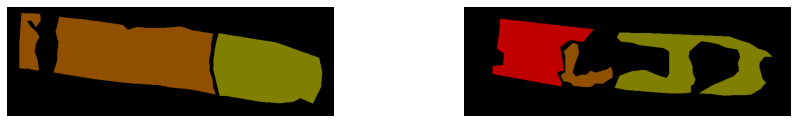

In [7]:
###Making RBG y pics from one channel data

#Help function to get RGB codes from DEC
def get_rgb_from_codes(inp):
    return np.array([[i//65536,(i - 65536*(i//65536))//256, i - 65536*(i//65536) - 256*((i - 65536*(i//65536))//256)] for i in inp]).astype(np.uint8)

def multichannel_to_rgb(inp):

    list_of_colors = get_rgb_from_codes(list_of_codes_colors)
    
    res_r = np.argmax(inp, axis=3)
    res_g = np.copy(res_r)
    res_b = np.copy(res_r)

    for c in range(inp.shape[-1]):
        res_r[res_r == c] =  list_of_colors[c,0]
        res_g[res_g == c] =  list_of_colors[c,1]
        res_b[res_b == c] =  list_of_colors[c,2]

    return np.concatenate([res_r[...,None],res_g[...,None],res_b[...,None]], axis=3)

if not sp_y_is_rgb:
    images_y_raw = multichannel_to_rgb(y_result)

dbug.show_images_list(images_y_raw[:2,...], col_number = 2) 

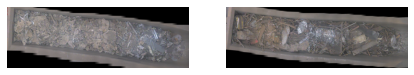

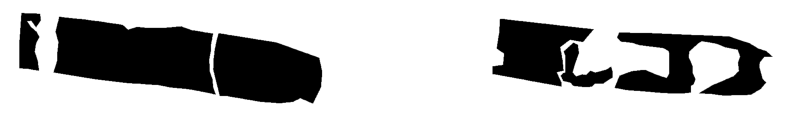

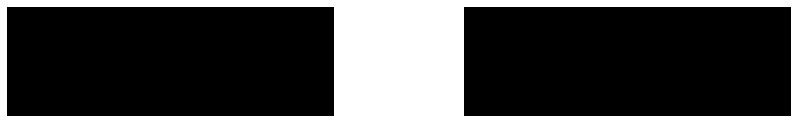

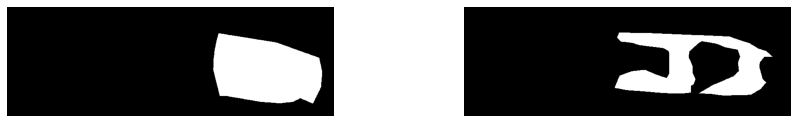

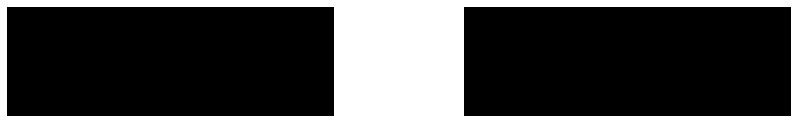

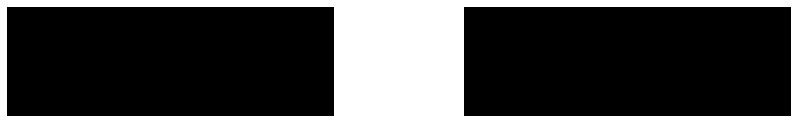

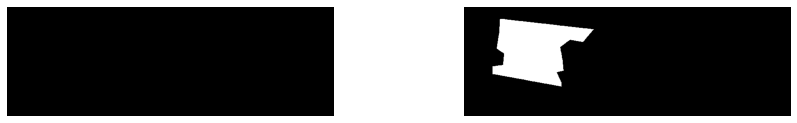

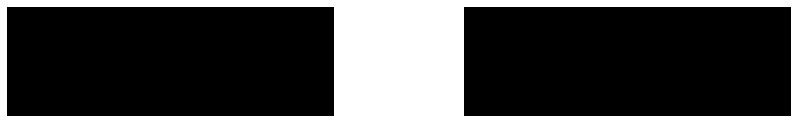

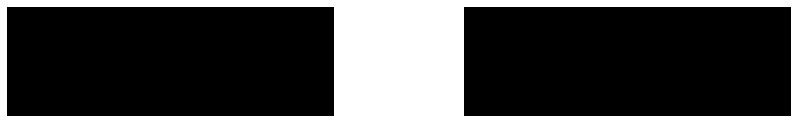

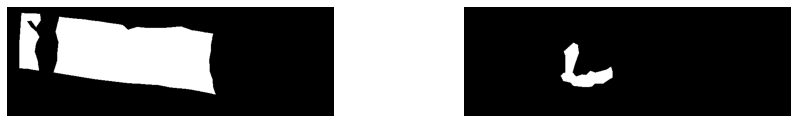

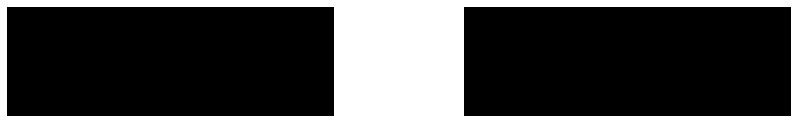

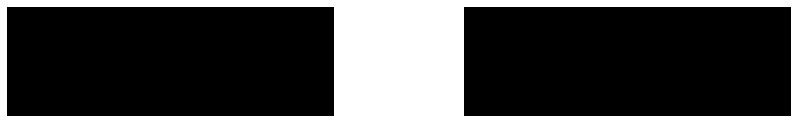

In [8]:
###ACTIVE CELL###
###Shuffle X and Y together

##IGNORE SHUFFLING BECAUSE EXPORTING Y MULTICOLOR IMAGES ALSO
x_result_shuff, y_result_shuff = x_result, y_result #bill_img_gen.shuffle_x_y(x_result, y_result)

#Show some result images
dbug.show_images_list(x_result_shuff[:2], col_number = 4)
for c in range(len(list_of_codes)):
    dbug.show_images_list(y_result_shuff[:2,...,c], col_number = 2) 

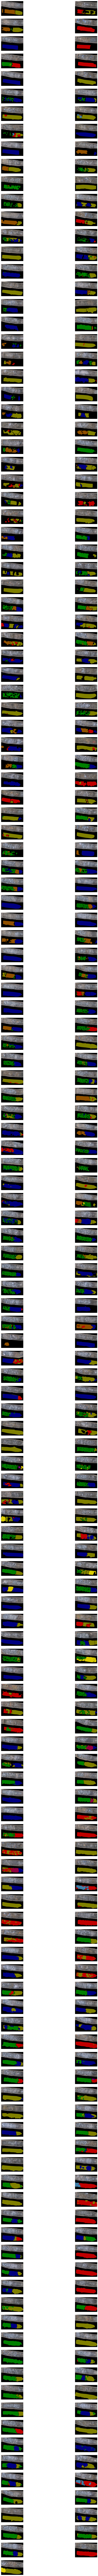

In [14]:
#ACTIVE CELL. Making export image for check
###Exporting images
dbug.show_images_list(np.concatenate([x_result_shuff,images_y_raw.astype('uint8')], axis=1), col_number = 2, save_name='export') 


In [14]:
###ACTIVE CELL###
###Save data to file
Image_generator.save_data(x_result_shuff, y_result_shuff, images_y_raw, save_dir = "../../Data/scrapid/training_data/", name="scrapid_11c_768x256_293_1")

x_load.shape = (10, 256, 768, 3) , y_load.shape = (10, 256, 768, 9)


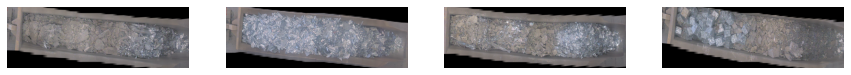

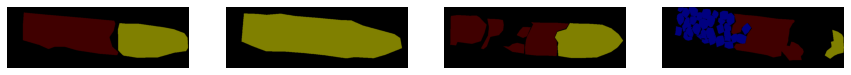

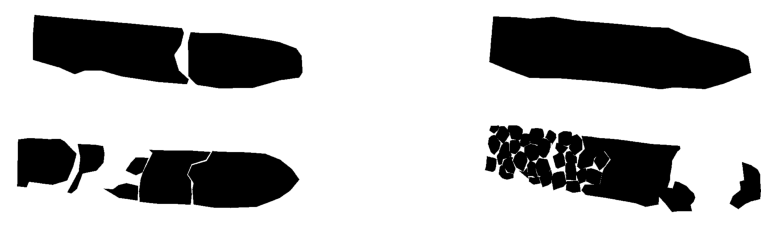

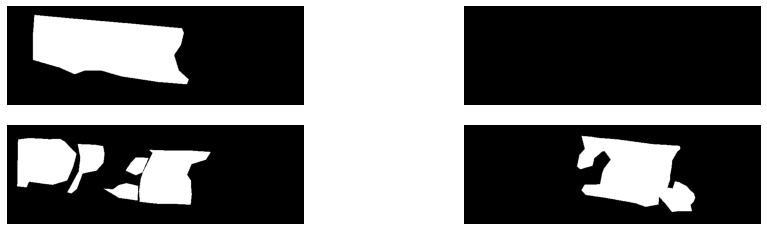

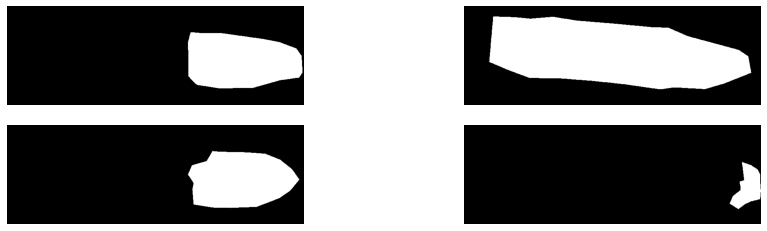

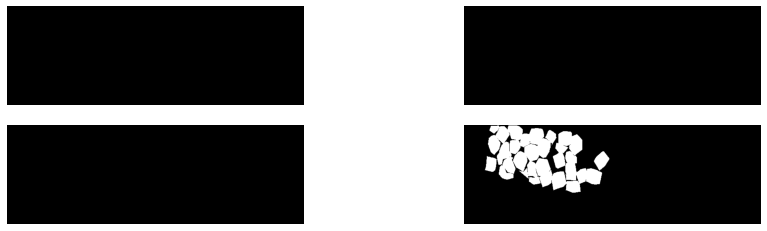

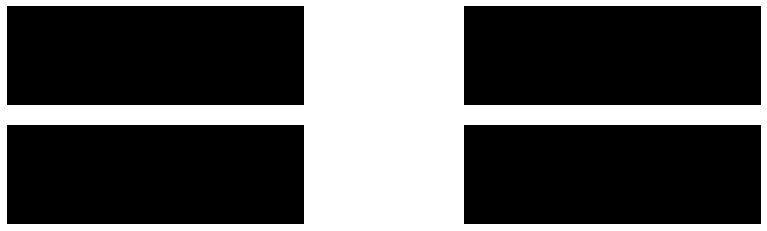

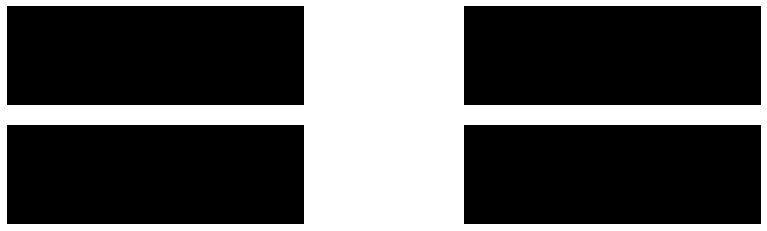

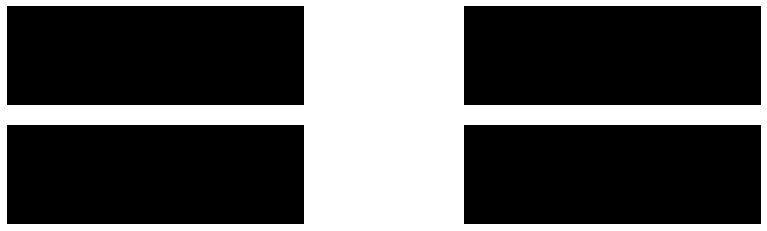

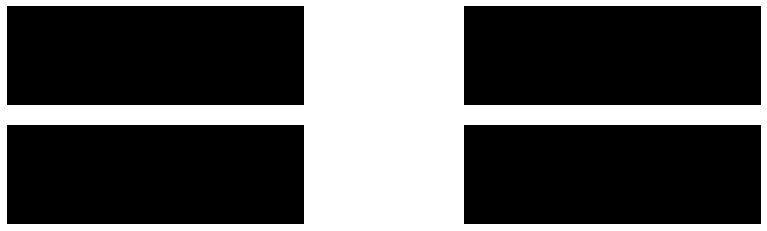

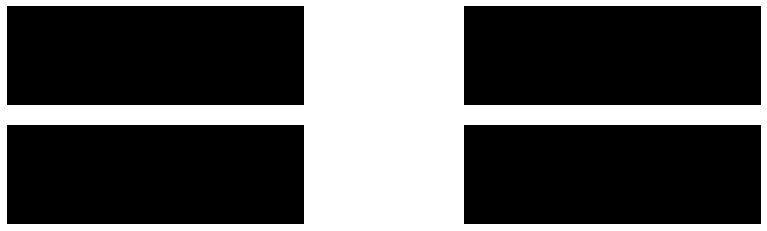

In [30]:
####TEST CELL#####
###Load data
###Testing that data has been saved and can be loaded

x_load, y_load , y_load_raw  = Image_generator.load_data(save_dir = "../../Data/scrapid/training_data/", name="scrapid_7c_768x256_10_1")

#Show some result images
print('x_load.shape =',x_load.shape,',', 'y_load.shape =',y_load.shape)
dbug.show_images_list(x_load[:4], col_number = 4)
dbug.show_images_list(y_load_raw[:4], col_number = 4)
for c in range(y_load.shape[-1]):
    dbug.show_images_list(y_load[:4,...,c], col_number = 2) 